Source data: 

[0](https://archive.stsci.edu/k2/preview.php?dsn=KTWO211928486-C16&type=LC), [1](https://archive.stsci.edu/k2/preview.php?dsn=KTWO211966629-C16&type=LC)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from astropy.io import fits

c16_sap_0 = fits.getdata('../data/ktwo211928486-c16_llc.fits', ext=1)
c16_sap_1 = fits.getdata('../data/ktwo211966629-c16_llc.fits', ext=1)

In [3]:
np.count_nonzero(np.isnan(c16_sap_1['SAP_FLUX']))

55

In [4]:
times_c5_0, flux_c5_0 = np.loadtxt("C05_211928486.txt", unpack=True)
times_c5_1, flux_c5_1 = np.loadtxt("C05_211966629.txt", unpack=True)

times_c16_0, flux_c16_0 = c16_sap_0['TIME'], c16_sap_0['PDCSAP_FLUX'] #np.loadtxt("C16_211928486.txt", unpack=True)
times_c16_1, flux_c16_1 = c16_sap_1['TIME'], c16_sap_1['PDCSAP_FLUX'] #np.loadtxt("C16_211966629.txt", unpack=True)

times_c16_0, flux_c16_0 = times_c16_0[~np.isnan(flux_c16_0)], flux_c16_0[~np.isnan(flux_c16_0)]
times_c16_1, flux_c16_1 = times_c16_1[~np.isnan(flux_c16_1)], flux_c16_1[~np.isnan(flux_c16_1)]

for time in [times_c5_0, times_c5_1, times_c16_0, times_c16_1]:
    time += 2454833
    
# flux_c16_0 = flux_c16_0 / np.polyval(np.polyfit(times_c16_0, flux_c16_0, 1), times_c16_0)
flux_c16_0 /= np.percentile(flux_c16_0, 98)

# flux_c16_1 = flux_c16_1 / np.polyval(np.polyfit(times_c16_1, flux_c16_1, 1), times_c16_1)
flux_c16_1 /= np.percentile(flux_c16_1, 98)

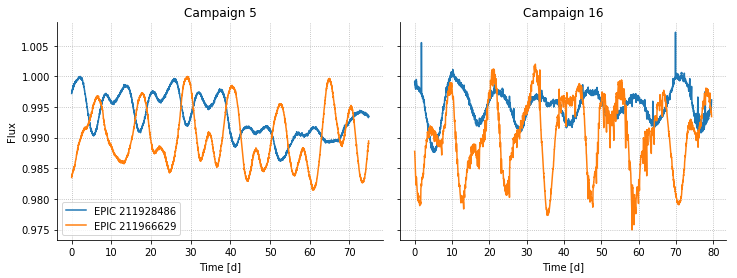

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

counter = 0

ax[0].plot(times_c5_0 - times_c5_0.min(), flux_c5_0, label='EPIC 211928486')
ax[0].plot(times_c5_1 - times_c5_0.min(), flux_c5_1, label='EPIC 211966629')
ax[0].legend(loc='lower left')

ax[1].plot(times_c16_0 - times_c16_0.min(), flux_c16_0)
ax[1].plot(times_c16_1 - times_c16_0.min(), flux_c16_1)

ax[0].set(xlabel='Time [d]', ylabel='Flux', title='Campaign 5')
ax[1].set(xlabel='Time [d]', title='Campaign 16')

for axis in ax:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=":")

fig.subplots_adjust(wspace=0.05)
fig.savefig('plots/everest_lightcurve.pdf', bbox_inches='tight')

In [22]:
from gatspy import periodic

model_0_5 = periodic.LombScargleFast(fit_period=True, silence_warnings=True, optimizer_kwds={'quiet':True})
model_0_5.optimizer.period_range = (8, 16)
model_0_5.fit(times_c5_0, flux_c5_0);
periods = np.linspace(model_0_5.optimizer.period_range[0], model_0_5.optimizer.period_range[1], 100)
scores_0_5 = model_0_5.score(periods)

model_0_16 = periodic.LombScargleFast(fit_period=True, silence_warnings=True, optimizer_kwds={'quiet':True})
model_0_16.optimizer.period_range = (8, 16)
model_0_16.fit(times_c16_0, flux_c16_0);
scores_0_16 = model_0_16.score(periods)

model_1_5 = periodic.LombScargleFast(fit_period=True, silence_warnings=True, optimizer_kwds={'quiet':True})
model_1_5.optimizer.period_range = (8, 16)
model_1_5.fit(times_c5_1, flux_c5_1);
periods = np.linspace(model_0_5.optimizer.period_range[0], model_1_5.optimizer.period_range[1], 100)
scores_1_5 = model_1_5.score(periods)


model_1_16 = periodic.LombScargleFast(fit_period=True, silence_warnings=True, optimizer_kwds={'quiet':True})
model_1_16.optimizer.period_range = (8, 16)
model_1_16.fit(times_c16_1, flux_c16_1);
scores_1_16 = model_1_16.score(periods)


from interpacf import interpolated_acf, dominant_period

lag_0_5, acf_0_5 = interpolated_acf(times_c5_0, flux_c5_0 - np.median(flux_c5_0))
period_0_5 = dominant_period(lag_0_5, acf_0_5)
lag_1_5, acf_1_5 = interpolated_acf(times_c5_1, flux_c5_1 - np.median(flux_c5_1))
period_1_5 = dominant_period(lag_1_5, acf_1_5)
lag_0_16, acf_0_16 = interpolated_acf(times_c16_0, flux_c16_0 - np.median(flux_c16_0))
period_0_16 = dominant_period(lag_0_16, acf_0_16 )
lag_1_16, acf_1_16 = interpolated_acf(times_c16_1, flux_c16_1 - np.median(flux_c16_1))
period_1_16 = dominant_period(lag_1_16, acf_1_16)

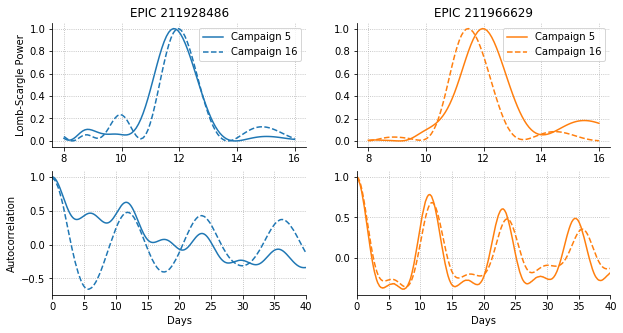

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0, 0].plot(periods, scores_0_5/scores_0_5.max(), color='C0', label='Campaign 5')
ax[0, 0].plot(periods, scores_0_16/scores_0_16.max(), ls='--', color='C0', label='Campaign 16')
ax[0, 0].legend()
              
ax[0, 1].plot(periods, scores_1_5/scores_1_5.max(), color='C1', label='Campaign 5')
ax[0, 1].plot(periods, scores_1_16/scores_1_16.max(), color='C1', ls='--', label='Campaign 16')
ax[0, 1].legend()

ax[0, 0].set(ylabel='Lomb-Scargle Power', title='EPIC 211928486')
ax[0, 1].set(title='EPIC 211966629')


ax[1, 0].set(ylabel='Autocorrelation', xlabel='Days', xlim=[0, 40])
ax[1, 0].plot(lag_0_5, acf_0_5/acf_0_5.max(), color='C0', label='Campaign 5')
ax[1, 0].plot(lag_0_16, acf_0_16/acf_0_16.max(), ls='--', color='C0', label='Campaign 16')

ax[1, 1].plot(lag_1_16, acf_1_16/acf_1_16.max(), color='C1')
ax[1, 1].plot(lag_1_5, acf_1_5/acf_1_5.max(), ls='--', color='C1')


for axis in fig.axes:
    axis.grid(ls=':')
    
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)

ax[1, 1].set(xlabel='Days', xlim=[0, 40])
        
fig.savefig('plots/periodograms.pdf', bbox_inches='tight')
plt.show()

In [8]:
periods_0 = np.array([model_0_5.best_period, model_0_16.best_period, period_0_5, period_0_16])
periods_1 = np.array([model_1_5.best_period, model_1_16.best_period, period_1_5, period_1_16])

print('period 211928486: {0} +- {1}'.format(periods_0.mean(), periods_0.std()))
print('period 211966629: {0} +- {1}'.format(periods_1.mean(), periods_1.std()))

period 211928486: 11.806664419413359 +- 0.11818831171667095
period 211966629: 11.68608126493875 +- 0.22851255311254304


### Flux deficit:

In [9]:
c = 0.7

def fs(flux): 
    return (1 - np.min(flux))/(1 - c)

print('c05 211928486', fs(flux_c5_0))
print('c16 211928486', fs(flux_c16_0))

print('c05 211966629', fs(flux_c5_1))
print('c16 211966629', fs(flux_c16_1))

c05 211928486 0.0460119726934
c16 211928486 0.041233698527
c05 211966629 0.0618107223584
c16 211966629 0.083549618721


### H$\alpha$

In [10]:
from json import load

ha_0 = load(open('/Users/bmmorris/git/arces_hk/data/EPIC211928486_ha.json', 'r'))
ha_0['ha'] = np.array(ha_0['ha'])[np.argsort(ha_0['time'])]
ha_0['time'] = np.array(ha_0['time'])[np.argsort(ha_0['time'])]
ha_1 = load(open('/Users/bmmorris/git/arces_hk/data/EPIC211966629_ha.json', 'r'))
ha_1['ha'] = np.array(ha_1['ha'])[np.argsort(ha_1['time'])]
ha_1['time'] = np.array(ha_1['time'])[np.argsort(ha_1['time'])]

## $S$ index

In [11]:
import sys
sys.path.insert(0, '/Users/bmmorris/git/arces_hk/')

from toolkit import json_to_stars

star_0 = json_to_stars('/Users/bmmorris/git/arces_hk/data/EPIC211928486_apo_calibrated.json')
star_1 = json_to_stars('/Users/bmmorris/git/arces_hk/data/EPIC211966629_apo_calibrated.json')

In [12]:
times_0 = np.array([s.s_mwo.time.jd for s in star_0])
times_1 = np.array([s.s_mwo.time.jd for s in star_1])

sort_0 = np.argsort(times_0)
sort_1 = np.argsort(times_1)

sindex_0 = np.array([s.s_mwo.value for s in star_0])[sort_0]
sindex_1 = np.array([s.s_mwo.value for s in star_1])[sort_1]

sindex_0_err = np.array([s.s_mwo.err for s in star_0])[sort_0]
sindex_1_err = np.array([s.s_mwo.err for s in star_1])[sort_1]

times_0 = times_0[sort_0]
times_1 = times_1[sort_1]

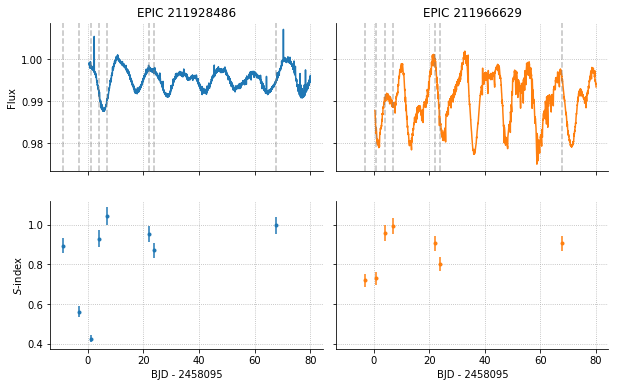

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey='row')

minint = int(times_c16_0.min())

ax[0, 0].plot(times_c16_0 - minint, flux_c16_0)
ax[0, 1].plot(times_c16_1 - minint, flux_c16_1, color='C1')

ax[0, 0].set(title='EPIC 211928486', ylabel='Flux')
ax[0, 1].set(title='EPIC 211966629')

ax[1, 0].set(xlabel='BJD - {0}'.format(minint), ylabel='$S$-index')
ax[1, 1].set(xlabel='BJD - {0}'.format(minint))

ax[1, 0].errorbar(times_0 - minint, sindex_0, sindex_0_err, fmt='.')
ax[1, 1].errorbar(times_1 - minint, sindex_1, sindex_1_err, fmt='.', color='C1')

for time in times_0 - minint: 
    ax[0, 0].axvline(time, ls='--', color='gray', alpha=0.5)
    
for time in times_1 - minint: 
    ax[0, 1].axvline(time, ls='--', color='gray', alpha=0.5)

for axis in fig.axes:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=":")
    
fig.subplots_adjust(wspace=0.05)
fig.savefig('plots/photometry_sindices.pdf', bbox_inches='tight')

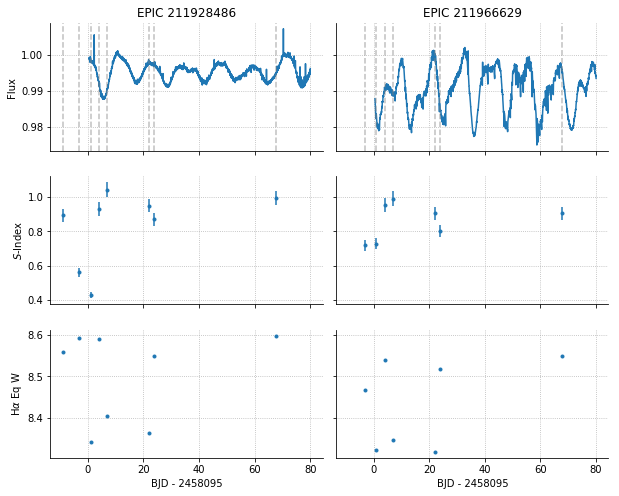

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8), sharex=True, sharey='row')

minint = int(times_c16_0.min())
 
ax[0, 0].plot(times_c16_0 - minint, flux_c16_0)
ax[0, 1].plot(times_c16_1 - minint, flux_c16_1)

ax[0, 0].set(title='EPIC 211928486', ylabel='Flux')
ax[0, 1].set(title='EPIC 211966629')

ax[1, 0].set(ylabel='$S$-Index')


ax[2, 0].plot(np.array(ha_0['time']) - minint, ha_0['ha'], '.')

ax[2, 1].plot(np.array(ha_1['time']) - minint, ha_1['ha'], '.')


ax[2, 0].set(xlabel='BJD - {0}'.format(minint), ylabel=r'H$\alpha$ Eq W')
ax[2, 1].set(xlabel='BJD - {0}'.format(minint))

ax[1, 0].errorbar(times_0 - minint, sindex_0, sindex_0_err, fmt='.')
ax[1, 1].errorbar(times_1 - minint, sindex_1, sindex_1_err, fmt='.')

for time in times_0 - minint: 
    ax[0, 0].axvline(time, ls='--', color='gray', alpha=0.5)
    
for time in times_1 - minint: 
    ax[0, 1].axvline(time, ls='--', color='gray', alpha=0.5)

for axis in fig.axes:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=":")
    
fig.subplots_adjust(wspace=0.05)
fig.savefig('plots/photometry_sindices_ha.pdf', bbox_inches='tight')

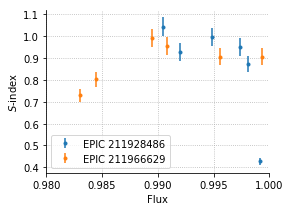

In [30]:
fig, ax = plt.subplots(figsize=(4, 3))

nearest_flux_0 = np.array([flux_c16_0[np.argmin(np.abs(t - times_c16_0))] for t in times_0[2:]])
nearest_flux_1 = np.array([flux_c16_1[np.argmin(np.abs(t - times_c16_1))] for t in times_1[1:]])

a0 = np.vander(nearest_flux_0, 2)
b0 = sindex_0[2:]
Omega_0 = np.diag(sindex_0_err[2:]**2)
inv_Omega_0 = np.linalg.inv(Omega_0)
c0 = np.linalg.inv(a0.T @ inv_Omega_0 @ a0) @ a0.T @ inv_Omega_0 @ b0


a1 = np.vander(nearest_flux_1, 2)
b1 = sindex_1[1:]
Omega_1 = np.diag(sindex_1_err[1:]**2)
inv_Omega_1 = np.linalg.inv(Omega_1)
c1 = np.linalg.inv(a1.T @ inv_Omega_1 @ a1) @ a1.T @ inv_Omega_1 @ b1

ax.errorbar(nearest_flux_0, sindex_0[2:], sindex_0_err[2:], fmt='.', label='EPIC 211928486')
ax.errorbar(nearest_flux_1, sindex_1[1:], sindex_1_err[1:], fmt='.', label='EPIC 211966629')

# ax.plot(nearest_flux_0, a0 @ c0, color='C0', label='EPIC 211928486')
# ax.plot(nearest_flux_1, a1 @ c1, color='C1', label='EPIC 211966629')

ax.set(xlabel='Flux', ylabel='$S$-index')

ax.set_xlim([0.98, 1])
ax.legend()

ax.grid(ls=':')

for axis in fig.axes:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
        
fig.savefig('plots/sind_flux_corr.pdf', bbox_inches='tight')

In [16]:
np.savetxt('fluxes_EPIC211928486.txt', np.vstack([times_0[2:], nearest_flux_0]).T)
np.savetxt('fluxes_EPIC211966629.txt', np.vstack([times_1[1:], nearest_flux_1]).T)

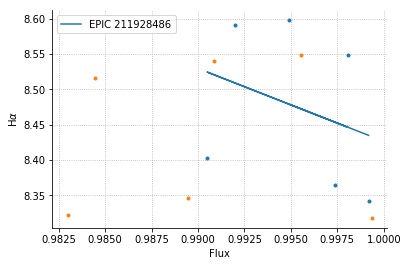

In [26]:
fig, ax = plt.subplots()

nearest_flux_0 = np.array([flux_c16_0[np.argmin(np.abs(t - times_c16_0))] for t in ha_0['time'][2:]])#times_0[2:]])
nearest_flux_1 = np.array([flux_c16_1[np.argmin(np.abs(t - times_c16_1))] for t in ha_1['time'][1:]]) #times_1[1:]])

a0 = np.vander(nearest_flux_0, 2)
b0 = ha_0['ha'][2:]
Omega_0 = np.diag(np.ones_like(ha_0['ha'])[2:]**2)
inv_Omega_0 = np.linalg.inv(Omega_0)
c0 = np.linalg.inv(a0.T @ inv_Omega_0 @ a0) @ a0.T @ inv_Omega_0 @ b0


a1 = np.vander(nearest_flux_1, 2)
b0 = ha_1['ha'][1:]
Omega_0 = np.diag(np.ones_like(ha_1['ha'])[1:]**2)
inv_Omega_1 = np.linalg.inv(Omega_1)
c1 = np.linalg.inv(a1.T @ inv_Omega_1 @ a1) @ a1.T @ inv_Omega_1 @ b1

ax.plot(nearest_flux_0, ha_0['ha'][2:], '.')
ax.plot(nearest_flux_1, ha_1['ha'][1:], '.')

ax.plot(nearest_flux_0, a0 @ c0, color='C0', label='EPIC 211928486')

# ax.plot(nearest_flux_1, a1 @ c1, color='C1', label='EPIC 211966629')

ax.set(xlabel='Flux', ylabel=r'H$\alpha$')

# ax.set_xlim([0.98, 1])
ax.legend()

ax.grid(ls=':')

for axis in fig.axes:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
        
# fig.savefig('plots/sind_flux_corr.pdf', bbox_inches='tight')